In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import OrderedDict


In [3]:
class MaxPooling(nn.Module):
    def __init__(self, dim):
        super(MaxPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.max(input, self.dim)[0]


In [4]:

class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, input):
        return torch.sum(input, self.dim)

In [5]:
class Dice(nn.Module):
    """
    The Data Adaptive Activation Function in DIN, a generalization of PReLu.
    """
    def __init__(self, emb_size, dim=2, epsilon=1e-8):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3

        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim
        
        # wrap alpha in nn.Parameter to make it trainable
        self.alpha = nn.Parameter(torch.zeros((emb_size,))) if self.dim == 2 else nn.Parameter(
            torch.zeros((emb_size, 1)))


    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        return out


In [6]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

In [7]:
def get_activation_layer(name, hidden_size=None, dice_dim=2):
    name = name.lower()
    name_dict = {x.lower():x for x in dir(nn) if '__' not in x and 'Z'>=x[0]>='A'}
    if name=="linear":
        return Identity()
    elif name=="dice":
        assert dice_dim
        return Dice(hidden_size, dice_dim)
    else:
        assert name in name_dict, f'activation type {name} not supported!'
        return getattr(nn,name_dict[name])()

In [8]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        if model.weight is not None:
            nn.init.kaiming_uniform_(model.weight.data)
        if model.bias is not None:
            nn.init.normal_(model.bias.data)
    elif isinstance(model, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
        if model.weight is not None:
            nn.init.normal_(model.weight.data, mean=1, std=0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    else:
        pass

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers,
                 dropout=0.0, batchnorm=True, activation='relu'):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation,hidden_layer,2)
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return self.mlp(x)


In [10]:

class AttentionGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (Wr|Wn)
        self.weight_ih = nn.Parameter(
            torch.Tensor(2 * hidden_size, input_size))
        # (Ur|Un)
        self.weight_hh = nn.Parameter(
            torch.Tensor(2 * hidden_size, hidden_size))
        if bias:
            # (b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(2 * hidden_size))
            # (b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(2 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size)**0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, hx, att_score):

        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_n = gi.chunk(2, 1)
        h_r, h_n = gh.chunk(2, 1)

        resetgate = torch.sigmoid(i_r + h_r)
        newgate = torch.tanh(i_n + resetgate * h_n)
        att_score = att_score.view(-1, 1)
        hy = (1. - att_score) * hx + att_score * newgate
        
        return hy


In [11]:
class AttentionUpdateGateGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (Wu|Wr|Wn)
        self.weight_ih = nn.Parameter(
            torch.Tensor(3 * hidden_size, input_size))
        # (Uu|Ur|Un)
        self.weight_hh = nn.Parameter(
            torch.Tensor(3 * hidden_size, hidden_size))
        if bias:
            # (b_iu|b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            # (b_hu|b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size)**0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
            
    def forward(self, x, hx, att_score):
        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_u,i_r, i_n = gi.chunk(3, 1)
        h_u,h_r, h_n = gh.chunk(3, 1)

        updategate = torch.sigmoid(i_u + h_u)
        resetgate = torch.sigmoid(i_r + h_r)
        newgate = torch.tanh(i_n + resetgate * h_n)

        updategate = att_score.view(-1, 1) * updategate
        hy = (1-updategate)*hx +  updategate*newgate

        return hy

In [12]:
class DynamicGRU(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, gru_type='AGRU'):
        super(DynamicGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        if gru_type == 'AGRU':
            self.rnn = AttentionGRUCell(input_size, hidden_size, bias)
        elif gru_type == 'AUGRU':
            self.rnn = AttentionUpdateGateGRUCell(
                input_size, hidden_size, bias)

    def forward(self, x, att_scores, hx=None):
        is_packed_input = isinstance(x, nn.utils.rnn.PackedSequence)
        if not is_packed_input:
            raise NotImplementedError(
                "DynamicGRU only supports packed input")

        is_packed_att_scores = isinstance(att_scores, nn.utils.rnn.PackedSequence)
        if not is_packed_att_scores:
            raise NotImplementedError(
                "DynamicGRU only supports packed att_scores")

        x, batch_sizes, sorted_indices, unsorted_indices = x
        att_scores, _, _, _ = att_scores

        max_batch_size = batch_sizes[0]
        max_batch_size = int(max_batch_size)

        if hx is None:
            hx = torch.zeros(
                max_batch_size, self.hidden_size,
                dtype=x.dtype, device=x.device)

        outputs = torch.zeros(
            x.size(0), self.hidden_size,
            dtype=x.dtype, device=x.device)

        begin = 0
        for batch in batch_sizes:
            new_hx = self.rnn(
                x[begin: begin + batch],
                hx[0:batch],
                att_scores[begin: begin + batch])
            outputs[begin: begin + batch] = new_hx
            hx = new_hx
            begin += batch

        return nn.utils.rnn.PackedSequence(
            outputs, batch_sizes, sorted_indices, unsorted_indices)
    


In [13]:
class Attention(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_layers,
            dropout=0.0,
            batchnorm=True,
            activation='prelu',
            return_scores=False):
        
        super().__init__()
        self.return_scores = return_scores
        
        self.mlp = MLP(
            input_size=input_size * 4,
            hidden_layers=hidden_layers,
            dropout=dropout,
            batchnorm=batchnorm,
            activation=activation)
        self.fc = nn.Linear(hidden_layers[-1], 1)

    def forward(self, query, keys, keys_length):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()

        query = query.unsqueeze(1).expand(-1, max_length, -1)

        din_all = torch.cat(
            [query, keys, query - keys, query * keys], dim=-1)

        din_all = din_all.view(batch_size * max_length, -1)

        outputs = self.mlp(din_all)

        outputs = self.fc(outputs).view(batch_size, max_length)  # [B, T]

        # Scale
        outputs = outputs / (dim ** 0.5)

        # Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1))
        outputs[~mask] = -np.inf

        # Activation
        outputs = F.softmax(outputs, dim=1)  #DIN uses sigmoid,DIEN uses softmax; [B, T]

        if not self.return_scores:
            # Weighted sum
            outputs = torch.matmul(
                outputs.unsqueeze(1), keys).squeeze()  # [B, H]
        return outputs 

In [14]:
class AuxiliaryNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation='sigmoid'):
        super().__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation)
            previous_size = hidden_layer
        modules["final_layer"] = nn.Linear(previous_size, 1)
        self.mlp = nn.Sequential(modules)

    def forward(self, x):
        return torch.sigmoid(self.mlp(x))

In [15]:
class Interest(nn.Module):
    SUPPORTED_GRU_TYPE = ['GRU', 'AIGRU', 'AGRU', 'AUGRU']

    def __init__(
            self,
            input_size,
            gru_type='AUGRU',
            gru_dropout=0.0,
            att_hidden_layers=[80, 40],
            att_dropout=0.0,
            att_batchnorm=True,
            att_activation='prelu',
            use_negsampling=False):
        super(Interest, self).__init__()
        if gru_type not in Interest.SUPPORTED_GRU_TYPE:
            raise NotImplementedError(f"gru_type: {gru_type} is not supported")

        self.gru_type = gru_type
        self.use_negsampling = use_negsampling

        self.interest_extractor = nn.GRU(
            input_size=input_size,
            hidden_size=input_size,
            batch_first=True,
            bidirectional=False)

        if self.use_negsampling:
            self.auxiliary_net = AuxiliaryNet(
                input_size * 2, hidden_layers=[100, 50])

        if gru_type == 'GRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation)
            
            self.interest_evolution = nn.GRU(
                input_size=input_size,
                hidden_size=input_size,
                batch_first=True,
                bidirectional=False)
                
        elif gru_type == 'AIGRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation,
                return_scores=True)

            self.interest_evolution = nn.GRU(
                input_size=input_size,
                hidden_size=input_size,
                batch_first=True,
                bidirectional=False)
            
        elif gru_type == 'AGRU' or gru_type == 'AUGRU':
            self.attention = Attention(
                input_size=input_size,
                hidden_layers=att_hidden_layers,
                dropout=att_dropout,
                batchnorm=att_batchnorm,
                activation=att_activation,
                return_scores=True)

            self.interest_evolution = DynamicGRU(
                input_size=input_size,
                hidden_size=input_size,
                gru_type=gru_type)

    @staticmethod
    def get_last_state(states, keys_length):
        # states [B, T, H]
        batch_size, max_seq_length, hidden_size = states.size()

        mask = (torch.arange(max_seq_length, device=keys_length.device).repeat(
            batch_size, 1) == (keys_length.view(-1, 1) - 1))

        return states[mask]

    def cal_auxiliary_loss(
            self, states, click_seq, noclick_seq, keys_length):
        # states [B, T, H]
        # click_seq [B, T, H]
        # noclick_seq [B, T, H]
        # keys_length [B]
        batch_size, max_seq_length, embedding_size = states.size()

        mask = (torch.arange(max_seq_length, device=states.device).repeat(
            batch_size, 1) < keys_length.view(-1, 1)).float()

        click_input = torch.cat([states, click_seq], dim=-1)
        noclick_input = torch.cat([states, noclick_seq], dim=-1)
        embedding_size = embedding_size * 2

        click_p = self.auxiliary_net(
            click_input.view(
                batch_size * max_seq_length, embedding_size)).view(
                    batch_size, max_seq_length)[mask > 0].view(-1, 1)
        click_target = torch.ones(
            click_p.size(), dtype=torch.float, device=click_p.device)

        noclick_p = self.auxiliary_net(
            noclick_input.view(
                batch_size * max_seq_length, embedding_size)).view(
                    batch_size, max_seq_length)[mask > 0].view(-1, 1)
        noclick_target = torch.zeros(
            noclick_p.size(), dtype=torch.float, device=noclick_p.device)

        loss = F.binary_cross_entropy(
            torch.cat([click_p, noclick_p], dim=0),
            torch.cat([click_target, noclick_target], dim=0))

        return loss

    def forward(self, query, keys, keys_length, neg_keys=None):
        """
        Parameters
        ----------
        query: 2D tensor, [Batch, Hidden]
        keys: 3D tensor, [Batch, Time, Hidden]
        keys_length: 1D tensor, [Batch]
        neg_keys: 3D tensor, [Batch, Time, Hidden]

        Returns
        -------
        outputs: 2D tensor, [Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()

        packed_keys = pack_padded_sequence(
            keys,
            lengths=keys_length.squeeze().cpu(),
            batch_first=True,
            enforce_sorted=False)

        packed_interests, _ = self.interest_extractor(packed_keys)

        aloss = None
        if (self.gru_type != 'GRU') or self.use_negsampling:
            interests, _ = pad_packed_sequence(
                packed_interests,
                batch_first=True,
                padding_value=0.0,
                total_length=max_length)

            if self.use_negsampling:
                aloss = self.cal_auxiliary_loss(
                    interests[:, :-1, :],
                    keys[:, 1:, :],
                    neg_keys[:, 1:, :],
                    keys_length - 1)

        if self.gru_type == 'GRU':
            packed_interests, _ = self.interest_evolution(packed_interests)

            interests, _ = pad_packed_sequence(
                packed_interests,
                batch_first=True,
                padding_value=0.0,
                total_length=max_length)

            outputs = self.attention(query, interests, keys_length)

        elif self.gru_type == 'AIGRU':
            # attention
            scores = self.attention(query, interests, keys_length)
            interests = interests * scores.unsqueeze(-1)

            packed_interests = pack_padded_sequence(
                interests,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)
            _, outputs = self.interest_evolution(packed_interests)
            outputs = outputs.squeeze()

        elif self.gru_type == 'AGRU' or self.gru_type == 'AUGRU':
            # attention
            scores = self.attention(query, interests, keys_length)

            packed_interests = pack_padded_sequence(
                interests,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)

            packed_scores = pack_padded_sequence(
                scores,
                lengths=keys_length.squeeze().cpu(),
                batch_first=True,
                enforce_sorted=False)

            outputs, _ = pad_packed_sequence(
                self.interest_evolution(
                    packed_interests, packed_scores), batch_first=True)
            # pick last state
            outputs = Interest.get_last_state(
                outputs, keys_length.squeeze())

        return outputs, aloss

In [16]:
class AttentionGroup(object):
    def __init__(self, name, pairs,
                 hidden_layers, activation='dice', att_dropout=0.0,
                 gru_type='AUGRU', gru_dropout=0.0):
        self.name = name
        self.pairs = pairs
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.att_dropout = att_dropout
        self.gru_type = gru_type
        self.gru_dropout = gru_dropout

        self.related_feature_names = set()
        self.neg_feature_names = set()
        for pair in pairs:
            self.related_feature_names.add(pair['ad'])
            self.related_feature_names.add(pair['pos_hist'])
            if 'neg_hist' in pair:
                self.related_feature_names.add(pair['neg_hist'])
                self.neg_feature_names.add(pair['neg_hist'])

    def is_attention_feature(self, feature_name):
        if feature_name in self.related_feature_names:
            return True
        return False

    def is_neg_sampling_feature(self, feature_name):
        if feature_name in self.neg_feature_names:
            return True
        return False

    @property
    def pairs_count(self):
        return len(self.pairs)

In [17]:
    
class DIEN(nn.Module):
    def __init__(self, num_features,cat_features,seq_features, 
                 cat_nums,embedding_size, attention_groups,
                 mlp_hidden_layers, mlp_activation='prelu', mlp_dropout=0.0,
                 use_negsampling = False,
                 d_out = 1
                 ):
        super().__init__()
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.cat_nums = cat_nums 
        self.embedding_size = embedding_size
        
        self.attention_groups = attention_groups
        
        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_activation = mlp_activation
        self.mlp_dropout = mlp_dropout
        
        self.d_out = d_out
        self.use_negsampling = use_negsampling
        
        #embedding
        self.embeddings = OrderedDict()
        for feature in self.cat_features+self.seq_features:
            self.embeddings[feature] = nn.Embedding(
                self.cat_nums[feature], self.embedding_size, padding_idx=0)
            self.add_module(f"embedding:{feature}",self.embeddings[feature])

        self.sequence_poolings = OrderedDict()
        self.attention_poolings = OrderedDict()
        total_embedding_sizes = 0
        for feature in self.cat_features:
            total_embedding_sizes += self.embedding_size
        for feature in self.seq_features:
            if not self.is_neg_sampling_feature(feature):
                total_embedding_sizes += self.embedding_size
        
        #sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                self.sequence_poolings[feature] = MaxPooling(1)
                self.add_module(f"pooling:{feature}",self.sequence_poolings[feature])

        #attention_pooling
        for attention_group in self.attention_groups:
            self.attention_poolings[attention_group.name] = (
                self.create_attention_fn(attention_group))
            self.add_module(f"attention_pooling:{attention_group.name}",
                self.attention_poolings[attention_group.name])

        total_input_size = total_embedding_sizes+len(self.num_features)
        
        self.mlp = MLP(
            total_input_size,
            mlp_hidden_layers,
            dropout=mlp_dropout, batchnorm=True, activation=mlp_activation)
        
        self.final_layer = nn.Linear(mlp_hidden_layers[-1], self.d_out)
        self.apply(init_weights)
        
        
    def forward(self, x):
        final_layer_inputs = list()

        # linear
        number_inputs = list()
        for feature in self.num_features:
            number_inputs.append(x[feature].view(-1, 1))

        embeddings = OrderedDict()
        for feature in self.cat_features:
            embeddings[feature] = self.embeddings[feature](x[feature])

        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                embeddings[feature] = self.sequence_poolings[feature](
                    self.embeddings[feature](x[feature]))

        auxiliary_losses = []
        for attention_group in self.attention_groups:
            query = torch.cat(
                [embeddings[pair['ad']]
                 for pair in attention_group.pairs],
                dim=-1)
            pos_hist = torch.cat(
                [self.embeddings[pair['pos_hist']](
                    x[pair['pos_hist']]) for pair in attention_group.pairs],
                dim=-1)
            
            #hist_length = torch.sum(hist>0,axis=1)
            keys_length = torch.min(torch.cat(
                [torch.sum(x[pair['pos_hist']]>0,axis=1).view(-1, 1)
                 for pair in attention_group.pairs],
                dim=-1), dim=-1)[0]
    
            neg_hist = None
            if self.use_negsampling:
                neg_hist = torch.cat(
                    [self.embeddings[pair['neg_hist']](
                        x[pair['neg_hist']])
                     for pair in attention_group.pairs],
                    dim=-1)
                
            embeddings[attention_group.name], tmp_loss = (
                self.attention_poolings[attention_group.name](
                    query, pos_hist, keys_length, neg_hist))
            if tmp_loss is not None:
                auxiliary_losses.append(tmp_loss)

        emb_concat = torch.cat(number_inputs + [
            emb for emb in embeddings.values()], dim=-1)

        final_layer_inputs = self.mlp(emb_concat)

        output = self.final_layer(final_layer_inputs)
        
        auxiliary_avg_loss = None
        if auxiliary_losses:
            auxiliary_avg_loss = auxiliary_losses[0]
            size = len(auxiliary_losses)
            for i in range(1, size):
                auxiliary_avg_loss += auxiliary_losses[i]
            auxiliary_avg_loss /= size
            
        if  self.d_out==1:
            output = output.squeeze() 
            
        return output, auxiliary_avg_loss

    def create_attention_fn(self, attention_group):
        return Interest(
            attention_group.pairs_count * self.embedding_size,
            gru_type=attention_group.gru_type,
            gru_dropout=attention_group.gru_dropout,
            att_hidden_layers=attention_group.hidden_layers,
            att_dropout=attention_group.att_dropout,
            att_activation=attention_group.activation,
            use_negsampling=self.use_negsampling)
    
    def is_attention_feature(self, feature):
        for group in self.attention_groups:
            if group.is_attention_feature(feature):
                return True
        return False

    def is_neg_sampling_feature(self, feature):
        for group in self.attention_groups:
            if group.is_neg_sampling_feature(feature):
                return True
        return False

# 实现

In [18]:
import numpy as np 
import pandas as pd 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer 
from collections import Counter

In [19]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
        super().__init__() 
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())

            selected_terms = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(
                zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        return self

    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError:
                transformed_x.append(self.word2idx['__UNKNOWN__'])

        return np.asarray(transformed_x, dtype=np.int64)

    def dimension(self):
        return len(self.word2idx)

In [20]:
class SequenceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sep=' ', min_cnt=5, max_len=None,
                 word2idx=None, idx2word=None):
        super().__init__() 
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len

        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()

    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter()

            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                counter.update(words)
                max_len = max(max_len, len(words))

            if self.max_len is None:
                self.max_len = max_len

            # drop rare words
            words = sorted(
                list(filter(lambda x: counter[x] >= self.min_cnt, counter)))

            self.word2idx = dict(zip(words, range(1, len(words) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)

        if not self.idx2word:
            self.idx2word = {
                index: word for word, index in self.word2idx.items()}

        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len

        return self

    def transform(self, x):
        transformed_x = list()

        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])

            transformed_x.append(
                np.asarray(words[0:self.max_len], dtype=np.int64))

        return np.asarray(transformed_x, dtype=object)
    
    def dimension(self):
        return len(self.word2idx)

    def max_length(self):
        return self.max_len

In [21]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from tqdm import tqdm 


In [23]:
dftrain = pd.read_csv("train.csv")
dfval = pd.read_csv("test.csv")

for col in ["movieId","histHighRatedMovieIds","negHistMovieIds","genres"]:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['age']
cat_features = ['gender', 'movieId', 'occupation', 'zipCode']
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds']

num_pipe = Pipeline(steps = [('impute',SimpleImputer()),('quantile',QuantileTransformer())])

encoders = {}

print("preprocess number features...")
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.transform(dfval[num_features]).astype(np.float32)

print("preprocess category features...")
for col in tqdm(cat_features):
    encoders[col] = CategoryEncoder(min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
print("preprocess sequence features...")
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep="|",min_cnt=5)
    dftrain[col]  = encoders[col].fit_transform(dftrain[col])
    dfval[col] =  encoders[col].transform(dfval[col])
    
from collections import OrderedDict
from itertools import chain
from torch.utils.data import Dataset,DataLoader 

class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features,
                 seq_features, encoders, label_col="label"):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features 
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)

    def __len__(self):
        return self.size

    @staticmethod
    def pad_sequence(sequence,max_length):
        #zero is special index for padding
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0: sequence.shape[0]] = sequence
        return padded_seq

    def __getitem__(self, idx):
        record = OrderedDict()
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)
            
        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)
            
        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq,max_length)

        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record

    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)
    
ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval,num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128,shuffle=True)
dl_val = DataLoader(ds_val,batch_size=128,shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()} 

preprocess number features...
preprocess category features...


100%|██████████| 4/4 [00:00<00:00, 517.85it/s]


preprocess sequence features...


100%|██████████| 3/3 [00:00<00:00, 58.87it/s]


In [24]:
for batch in dl_train:
    break 

In [25]:
print(cat_nums)

{'gender': 4, 'movieId': 280, 'occupation': 23, 'zipCode': 124, 'genres': 20, 'histHighRatedMovieIds': 1791, 'negHistMovieIds': 3868}


# 定义模型

In [26]:
def create_net():
    augru_attention_groups_with_neg = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'movieId', 'pos_hist': 'histHighRatedMovieIds', 'neg_hist': 'negHistMovieIds'}],
        hidden_layers=[16, 8], att_dropout=0.1, gru_type='AUGRU')
    ]

    net = DIEN(num_features=num_features,
           cat_features=cat_features,
           seq_features=seq_features,
           cat_nums = cat_nums,
           embedding_size=16,
           attention_groups=augru_attention_groups_with_neg,
           mlp_hidden_layers=[32,16],
           mlp_activation="prelu",
           mlp_dropout=0.25,
           use_negsampling=True,
           d_out=1
           )
    
    return net 

net = create_net() 

out,aloss = net.forward(batch)

from torchkeras.summary import summary 
summary(net,input_data=batch);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 16]                   64
Embedding-2                                 [-1, 16]                4,480
Embedding-3                                 [-1, 16]                  368
Embedding-4                                 [-1, 16]                1,984
Embedding-5                              [-1, 6, 16]                  320
MaxPooling-6                                [-1, 16]                    0
Embedding-7                             [-1, 10, 16]               28,656
Embedding-8                             [-1, 10, 16]               61,888
GRU-9                                       [-1, 16]                1,632
Linear-10                                  [-1, 100]                3,300
Sigmoid-11                                 [-1, 100]                    0
Linear-12                            

# 训练模型

In [28]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from accelerate import Accelerator
from copy import deepcopy


In [29]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

In [30]:
class StepRunner:
    def __init__(self, net, loss_fn,stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None,
                 accelerator = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
    
    def __call__(self, batch):
        #loss
        preds,aloss = self.net(batch)
        loss = self.loss_fn(preds,batch["label"])+aloss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            if self.accelerator is  None:
                loss.backward()
            else:
                self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, batch["label"]).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics
    

In [32]:
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() if self.stage=="train" else self.steprunner.net.eval()
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop:
            if self.stage=="train":
                loss, step_metrics = self.steprunner(batch)
            else:
                with torch.no_grad():
                    loss, step_metrics = self.steprunner(batch)

            step_log = dict({self.stage+"_loss":loss},**step_metrics)

            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

In [33]:
class KerasModel(torch.nn.Module):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler = None):
        super().__init__()
        self.accelerator = Accelerator()
        self.history = {}
        
        self.net = net
        self.loss_fn = loss_fn
        self.metrics_dict = nn.ModuleDict(metrics_dict) 
        
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler
        
        self.net,self.loss_fn,self.metrics_dict,self.optimizer = self.accelerator.prepare(
            self.net,self.loss_fn,self.metrics_dict,self.optimizer)

    def forward(self, x):
        if self.net:
            return self.net.forward(x)[0]
        else:
            raise NotImplementedError


    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', 
            patience=5, monitor="val_loss", mode="min"):
        
        train_data = self.accelerator.prepare(train_data)
        val_data = self.accelerator.prepare(val_data) if val_data else []

        for epoch in range(1, epochs+1):
            printlog("Epoch {0} / {1}".format(epoch, epochs))
            
            # 1，train -------------------------------------------------  
            train_step_runner = StepRunner(net = self.net,stage="train",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    optimizer = self.optimizer, lr_scheduler = self.lr_scheduler,
                    accelerator = self.accelerator)
            train_epoch_runner = EpochRunner(train_step_runner)
            train_metrics = train_epoch_runner(train_data)
            
            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            # 2，validate -------------------------------------------------
            if val_data:
                val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
                val_epoch_runner = EpochRunner(val_step_runner)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_data)
                val_metrics["epoch"] = epoch
                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]
            
            # 3，early-stopping -------------------------------------------------
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
            if best_score_idx==len(arr_scores)-1:
                torch.save(self.net.state_dict(),ckpt_path)
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                     arr_scores[best_score_idx]),file=sys.stderr)
            if len(arr_scores)-best_score_idx>patience:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor,patience),file=sys.stderr)
                self.net.load_state_dict(torch.load(ckpt_path))
                break 
            
        return pd.DataFrame(self.history)

    @torch.no_grad()
    def evaluate(self, val_data):
        val_data = self.accelerator.prepare(val_data)
        val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    accelerator = self.accelerator)
        val_epoch_runner = EpochRunner(val_step_runner)
        val_metrics = val_epoch_runner(val_data)
        return val_metrics
        
       
    @torch.no_grad()
    def predict(self, dataloader):
        dataloader = self.accelerator.prepare(dataloader)
        self.net.eval()
        result = torch.cat([self.forward(t) for t in dataloader])
        return result.data

In [34]:
from torchkeras.metrics import AUC

loss_fn = nn.BCEWithLogitsLoss()

metrics_dict = {"auc":AUC()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=0.001) 
#lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer,
                   #lr_scheduler = lr_scheduler
                  )    

In [35]:
dfhistory = model.fit(train_data=dl_train,val_data=dl_val,epochs=100, patience=10,
                      monitor = "val_auc",mode="max",ckpt_path='checkpoint.pt')



================================================================================2024-06-05 00:05:36
Epoch 1 / 100



100%|██████████| 10/10 [00:00<00:00, 22.32it/s, val_auc=0.571, val_loss=1.37]
<<<<<< reach best val_auc : 0.5709118843078613 >>>>>>



================================================================================2024-06-05 00:05:41
Epoch 2 / 100



100%|██████████| 10/10 [00:00<00:00, 23.14it/s, val_auc=0.579, val_loss=1.36]
<<<<<< reach best val_auc : 0.5790735483169556 >>>>>>



================================================================================2024-06-05 00:05:44
Epoch 3 / 100



100%|██████████| 10/10 [00:00<00:00, 23.95it/s, val_auc=0.592, val_loss=1.35]
<<<<<< reach best val_auc : 0.5921095013618469 >>>>>>



================================================================================2024-06-05 00:05:47
Epoch 4 / 100



100%|██████████| 10/10 [00:00<00:00, 23.99it/s, val_auc=0.595, val_loss=1.35]
<<<<<< reach best val_auc : 0.5951790809631348 >>>>>>



================================================================================2024-06-05 00:05:49
Epoch 5 / 100



100%|██████████| 10/10 [00:00<00:00, 24.29it/s, val_auc=0.605, val_loss=1.34]
<<<<<< reach best val_auc : 0.6054068803787231 >>>>>>



================================================================================2024-06-05 00:05:52
Epoch 6 / 100



100%|██████████| 10/10 [00:00<00:00, 23.03it/s, val_auc=0.61, val_loss=1.34]
<<<<<< reach best val_auc : 0.6104041337966919 >>>>>>



================================================================================2024-06-05 00:05:55
Epoch 7 / 100



100%|██████████| 10/10 [00:00<00:00, 24.39it/s, val_auc=0.611, val_loss=1.34]
<<<<<< reach best val_auc : 0.6114485263824463 >>>>>>



================================================================================2024-06-05 00:05:58
Epoch 8 / 100



100%|██████████| 10/10 [00:00<00:00, 24.59it/s, val_auc=0.613, val_loss=1.33]
<<<<<< reach best val_auc : 0.6133098602294922 >>>>>>



================================================================================2024-06-05 00:06:00
Epoch 9 / 100



100%|██████████| 10/10 [00:00<00:00, 23.12it/s, val_auc=0.614, val_loss=1.33]
<<<<<< reach best val_auc : 0.6141167879104614 >>>>>>



================================================================================2024-06-05 00:06:03
Epoch 10 / 100



100%|██████████| 10/10 [00:00<00:00, 21.96it/s, val_auc=0.615, val_loss=1.33]
<<<<<< reach best val_auc : 0.6153095960617065 >>>>>>



================================================================================2024-06-05 00:06:06
Epoch 11 / 100



100%|██████████| 10/10 [00:00<00:00, 22.94it/s, val_auc=0.617, val_loss=1.32]
<<<<<< reach best val_auc : 0.616597056388855 >>>>>>



================================================================================2024-06-05 00:06:09
Epoch 12 / 100



100%|██████████| 10/10 [00:00<00:00, 22.53it/s, val_auc=0.623, val_loss=1.31]
<<<<<< reach best val_auc : 0.6226246356964111 >>>>>>



================================================================================2024-06-05 00:06:12
Epoch 13 / 100



100%|██████████| 10/10 [00:00<00:00, 23.02it/s, val_auc=0.621, val_loss=1.3]



================================================================================2024-06-05 00:06:15
Epoch 14 / 100



100%|██████████| 10/10 [00:00<00:00, 21.16it/s, val_auc=0.626, val_loss=1.29]
<<<<<< reach best val_auc : 0.6255429983139038 >>>>>>



================================================================================2024-06-05 00:06:18
Epoch 15 / 100



100%|██████████| 10/10 [00:00<00:00, 22.85it/s, val_auc=0.626, val_loss=1.27]
<<<<<< reach best val_auc : 0.6258554458618164 >>>>>>



================================================================================2024-06-05 00:06:21
Epoch 16 / 100



100%|██████████| 10/10 [00:00<00:00, 22.43it/s, val_auc=0.628, val_loss=1.24]
<<<<<< reach best val_auc : 0.6281265020370483 >>>>>>



================================================================================2024-06-05 00:06:24
Epoch 17 / 100



100%|██████████| 10/10 [00:00<00:00, 22.93it/s, val_auc=0.63, val_loss=1.19]
<<<<<< reach best val_auc : 0.6303128004074097 >>>>>>



================================================================================2024-06-05 00:06:27
Epoch 18 / 100



100%|██████████| 10/10 [00:00<00:00, 20.45it/s, val_auc=0.625, val_loss=1.13]



================================================================================2024-06-05 00:06:30
Epoch 19 / 100



100%|██████████| 10/10 [00:00<00:00, 23.23it/s, val_auc=0.632, val_loss=1.04]
<<<<<< reach best val_auc : 0.6324709057807922 >>>>>>



================================================================================2024-06-05 00:06:33
Epoch 20 / 100



100%|██████████| 10/10 [00:00<00:00, 22.02it/s, val_auc=0.631, val_loss=0.952]



================================================================================2024-06-05 00:06:36
Epoch 21 / 100



100%|██████████| 10/10 [00:00<00:00, 22.54it/s, val_auc=0.644, val_loss=0.872]
<<<<<< reach best val_auc : 0.6444807648658752 >>>>>>



================================================================================2024-06-05 00:06:39
Epoch 22 / 100



100%|██████████| 10/10 [00:00<00:00, 22.64it/s, val_auc=0.637, val_loss=0.812]



================================================================================2024-06-05 00:06:41
Epoch 23 / 100



100%|██████████| 10/10 [00:00<00:00, 23.00it/s, val_auc=0.64, val_loss=0.771]



================================================================================2024-06-05 00:06:44
Epoch 24 / 100



100%|██████████| 10/10 [00:00<00:00, 22.72it/s, val_auc=0.64, val_loss=0.745]



================================================================================2024-06-05 00:06:47
Epoch 25 / 100



100%|██████████| 10/10 [00:00<00:00, 22.15it/s, val_auc=0.634, val_loss=0.734]



================================================================================2024-06-05 00:06:50
Epoch 26 / 100



100%|██████████| 10/10 [00:00<00:00, 22.01it/s, val_auc=0.642, val_loss=0.714]



================================================================================2024-06-05 00:06:53
Epoch 27 / 100



100%|██████████| 10/10 [00:00<00:00, 22.98it/s, val_auc=0.637, val_loss=0.718]



================================================================================2024-06-05 00:06:56
Epoch 28 / 100



100%|██████████| 10/10 [00:00<00:00, 22.60it/s, val_auc=0.636, val_loss=0.715]



================================================================================2024-06-05 00:06:59
Epoch 29 / 100



100%|██████████| 10/10 [00:00<00:00, 22.85it/s, val_auc=0.64, val_loss=0.713]



================================================================================2024-06-05 00:07:02
Epoch 30 / 100



100%|██████████| 10/10 [00:00<00:00, 22.32it/s, val_auc=0.631, val_loss=0.718]



================================================================================2024-06-05 00:07:05
Epoch 31 / 100



100%|██████████| 10/10 [00:00<00:00, 22.60it/s, val_auc=0.633, val_loss=0.717]
<<<<<< val_auc without improvement in 10 epoch, early stopping >>>>>>


# 评估模型

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

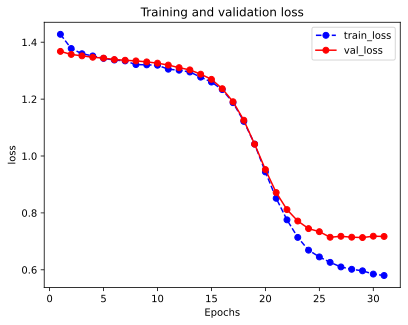

In [37]:
plot_metric(dfhistory,"loss")

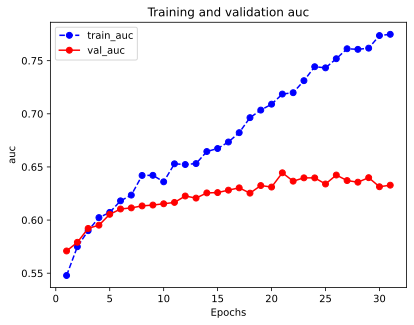

In [38]:
plot_metric(dfhistory,"auc")

In [39]:
model.evaluate(dl_val)

100%|██████████| 10/10 [00:00<00:00, 20.38it/s, val_auc=0.644, val_loss=0.872]


{'val_loss': 0.8715359985828399, 'val_auc': 0.6444807648658752}